In [336]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

**House price dataset:** http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls

In [337]:
df =  pd.read_excel('AmesHousing.xls')

In [338]:
df.head(5)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


## STEP 1:Data cleaning

In [339]:
#check the number of features except PID and order
df_PID = df['PID']#save PID
df_order =df['Order']#save order
df.drop("PID", axis = 1, inplace = True)
df.drop("Order", axis = 1, inplace = True)

In [340]:
df.shape 

(2930, 80)

In [341]:
df.head(5)

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


**check outliers for certain features**

In [342]:
numcol = list(df._get_numeric_data().columns) #Numeric data column
numcol

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Yr Blt',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice']

In [343]:
for i in numcol:
    if 'Year' in i:
        numcol.remove(i)
    elif 'Yr' in i:
        numcol.remove(i)
        
numcol.remove('SalePrice')
numcol# We remove year features and sale price

['MS SubClass',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Remod/Add',
 'Mas Vnr Area',
 'BsmtFin SF 1',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Total Bsmt SF',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Bsmt Full Bath',
 'Bsmt Half Bath',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Garage Cars',
 'Garage Area',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold']

In [344]:
len(numcol)

33

**Use distributions to remove outliers**

In [345]:
class Outlier():
    '''
    class for removing outliers
    Input：pandas.dataframe, col(list), up/low_bound(sigma)
    return: dataframe
    '''
    def __init__(self, data):
        self.data = data
    def __drawback(self, x, mean, std):
        '''
        transform
        '''
        if x >= self.up_bound:
            return self.up_bound*std + mean
        elif x <= self.low_bound:
            return self.low_bound*std + mean
        else:
            return x*std + mean
    def box(self, col, up_bound, low_bound, drawback = True):
        '''
        data: dataframe object
        col: columns' name, list
        '''
        # std
        self.up_bound = up_bound
        self.low_bound = low_bound
        for each_col in col:
            # mean
            mean = self.data[each_col].mean()
            # std
            std = self.data[each_col].std()
            self.data['help'] = self.data[each_col].map(lambda x: (x - mean)*1.0/std)
            if drawback:
                self.data[each_col] = self.data['help'].map(lambda x: self.__drawback(x, mean, std))
            else:
                self.data = self.data[(self.data['help'] <= self.up_bound)&(self.data['help'] >= self.low_bound)]
        del self.data['help']
        return self.data

In [346]:
Test = Outlier(df)
cleaned_df = Test.box(numcol, 1.96, -1.96)

**Log-transformation of the target variable**


 mu = 180796.06 and sigma = 79873.06



D:\anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'SalePrice distribution')

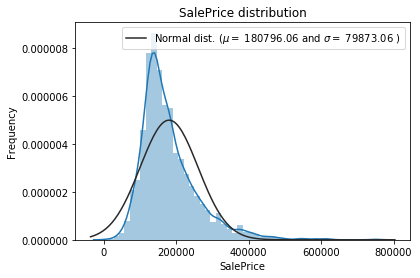

In [347]:
sns.distplot(cleaned_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(cleaned_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

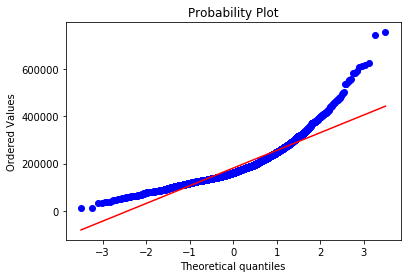

In [348]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(cleaned_df['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.41



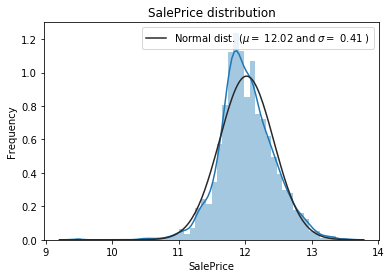

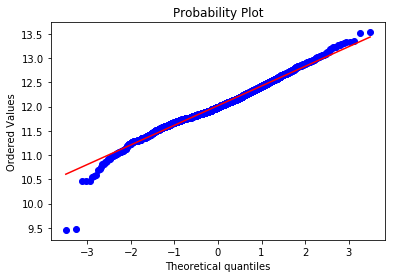

In [349]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
cleaned_df["SalePrice"] = np.log1p(cleaned_df["SalePrice"])

#Check the new distribution 
sns.distplot(cleaned_df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(cleaned_df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(cleaned_df['SalePrice'], plot=plt)
plt.show()


**Imputing missing values**

In [350]:
y = cleaned_df['SalePrice']
all_data = cleaned_df
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2930, 79)


In [351]:
y

0       12.278398
1       11.561725
2       12.055256
3       12.404928
4       12.154258
5       12.183321
6       12.271397
7       12.162648
8       12.373708
9       12.149508
10      12.077677
11      12.128117
12      12.102937
13      12.052344
14      12.264346
15      13.195616
16      12.007628
17      12.885205
18      11.856522
19      12.254868
20      12.154785
21      12.043560
22      12.283038
23      11.911708
24      11.917730
25      11.863589
26      11.744045
27      11.652696
28      12.122696
29      11.472114
          ...    
2900    12.676079
2901    12.820991
2902    12.793584
2903    11.308371
2904    12.278398
2905    12.007628
2906    11.941462
2907    11.344519
2908    11.556952
2909    11.751950
2910    11.927687
2911    11.748005
2912    11.894788
2913    11.198228
2914    11.282266
2915    11.849405
2916    11.429555
2917    11.379977
2918    11.283525
2919    11.413116
2920    11.170449
2921    11.924379
2922    12.144203
2923    11.982935
2924    11

In [352]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
Pool QC,99.556314
Misc Feature,96.382253
Alley,93.242321
Fence,80.477816
Fireplace Qu,48.532423
Lot Frontage,16.723549
Garage Yr Blt,5.426621
Garage Cond,5.426621
Garage Qual,5.426621
Garage Finish,5.426621


Text(0.5, 1.0, 'Percent missing data by feature')

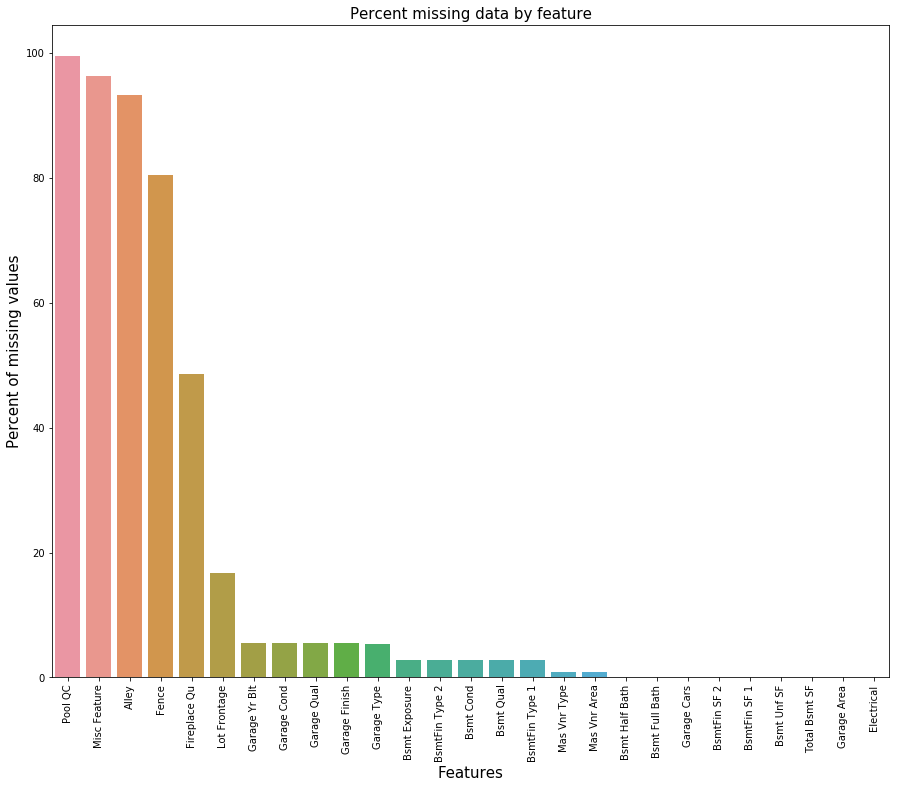

In [353]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [354]:
all_data["Pool QC"] = all_data["Pool QC"].fillna("None")
all_data["Misc Feature"] = all_data["Misc Feature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["Fireplace Qu"] = all_data["Fireplace Qu"].fillna("None")

In [355]:
all_data["Lot Frontage"] = all_data["Lot Frontage"].fillna(all_data["Lot Frontage"].mode()[0])

In [356]:
for col in ('Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond'):
    all_data[col] = all_data[col].fillna('None')

In [357]:
for col in ('Garage Yr Blt', 'Garage Area', 'Garage Cars'):
    all_data[col] = all_data[col].fillna(0)

In [358]:
for col in ('BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF','Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath'):
    all_data[col] = all_data[col].fillna(0)

In [359]:
for col in ('Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2'):
    all_data[col] = all_data[col].fillna('None')

In [360]:
all_data["Mas Vnr Type"] = all_data["Mas Vnr Type"].fillna("None")
all_data["Mas Vnr Area"] = all_data["Mas Vnr Area"].fillna(0)

In [361]:
all_data['MS Zoning'] = all_data['MS Zoning'].fillna(all_data['MS Zoning'].mode()[0])

In [362]:
all_data = all_data.drop(['Utilities'], axis=1) #this feature won't help in predictive modelling

In [363]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [364]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [365]:
all_data['Kitchen Qual'] = all_data['Kitchen Qual'].fillna(all_data['Kitchen Qual'].mode()[0])

In [366]:
all_data['Exterior 1st'] = all_data['Exterior 1st'].fillna(all_data['Exterior 1st'].mode()[0])
all_data['Exterior 2nd'] = all_data['Exterior 2nd'].fillna(all_data['Exterior 2nd'].mode()[0])

In [367]:
all_data['Sale Type'] = all_data['Sale Type'].fillna(all_data['Sale Type'].mode()[0])

In [368]:
all_data['MS SubClass'] = all_data['MS SubClass'].fillna("None")

In [369]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [370]:
#MSSubClass=The building class
all_data['MS SubClass'] = all_data['MS SubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['Overall Cond'] = all_data['Overall Cond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['Yr Sold'] = all_data['Yr Sold'].astype(str)
all_data['Mo Sold'] = all_data['Mo Sold'].astype(str)

In [371]:
from sklearn.preprocessing import LabelEncoder
cols = ('Fireplace Qu', 'Bsmt Qual', 'Bsmt Cond', 'Garage Qual', 'Garage Cond', 
        'Exter Qual', 'Exter Cond','Heating QC', 'Pool QC', 'Kitchen Qual', 'BsmtFin Type 1', 
        'BsmtFin Type 2', 'Functional', 'Fence', 'Bsmt Exposure', 'Garage Finish', 'Land Slope',
        'Lot Shape', 'Paved Drive', 'Street', 'Alley', 'Central Air', 'MS SubClass', 'Overall Cond', 
        'Yr Sold', 'Mo Sold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2930, 78)


In [372]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Pool Area,14.912715
3Ssn Porch,8.801743
Low Qual Fin SF,8.456403
Misc Val,6.523124
Land Slope,4.985612
Kitchen AbvGr,4.235177
Bsmt Half Bath,3.715693
Screen Porch,2.969826
BsmtFin SF 2,2.890488
Enclosed Porch,2.261729


In [373]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 58 skewed numerical features to Box Cox transform


In [374]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2930, 230)


## Modelling examples

In [375]:
X = all_data
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [376]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost as xgb
import lightgbm as lgb

In [377]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [378]:
model_xgb.fit(X_train, y_train)
xgb_pred = model_xgb.predict(X_test)
rms = sqrt(mean_squared_error(y_test, xgb_pred ))
rms

0.11225520477550299